In [1]:
import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import Dataset
import torch.nn.functional as F
import torchvision.models as models

import os
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

import slack_notification as sn

In [2]:
class SketchResModel(nn.Module):
    """
    https://github.com/HPrinz/sketch-recognition
    input size: (225. 225)
    """
    def __init__(self):
        super(SketchResModel, self).__init__()
        self.output_num = 10
        self.filer_num = 64
        self.act = nn.LeakyReLU(0.2)
        self.conv1 = self.conv_block(1, self.filer_num*1, kernel_size=15, stride=3, padding=0, act_fn=self.act)
        self.conv2 = self.conv_block(self.filer_num*1, self.filer_num*2, kernel_size=3, stride=1, padding=0, act_fn=self.act)
        self.conv3 = self.conv_block(self.filer_num*2, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv4 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv5 = self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act)
        self.conv6 = self.conv_block(self.filer_num*4, self.filer_num*8, kernel_size=7, stride=1, padding=0, act_fn=self.act)
        self.conv7 = self.conv_block(self.filer_num*8, self.filer_num*8, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        self.conv8 = self.conv_block(self.filer_num*8, 50, kernel_size=1, stride=1, padding=0, act_fn=self.act)
        self.out = nn.Sequential(
            nn.Linear(50, self.output_num),
            nn.Sigmoid(),
        )
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.drop = nn.Dropout2d(p=0.25)
        
        self.res_block = nn.Sequential(
            self.conv_block(self.filer_num*2, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act),
            self.conv_block(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1, act_fn=self.act),
            nn.Conv2d(self.filer_num*4, self.filer_num*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.filer_num*4),
        )
        self.residual = nn.Sequential(
            nn.Conv2d(self.filer_num*2, self.filer_num*4, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.filer_num*4),
        )
        
    def forward(self, input):
        h = self.pool(self.conv1(input))
        h = self.pool(self.conv2(h))
        #h = self.pool(self.conv5(self.conv4(self.conv3(h))))
        h1 = self.residual(h)
        h = self.pool(self.act(self.res_block(h) + h1))
        h = self.drop(self.conv6(h))
        h = self.conv8(self.drop(self.conv7(h)))
        h = self.out(self.flatten(h))
        return h
    
    def conv_block(self, in_dim, out_dim, kernel_size, stride, padding, act_fn):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size, stride, padding),
            nn.BatchNorm2d(out_dim),
            act_fn,
        )
    
    def flatten(self, x):
        bs = x.size()[0]
        return x.view(bs, -1)

In [3]:
data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(225),
    transforms.ToTensor(),
])

data_transform_2 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(250),
    transforms.RandomCrop(225),
    transforms.ToTensor(),
])

data_transform_3 = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(225),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

train_data = torchvision.datasets.ImageFolder(root='./train', transform=data_transform_3)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    
test_data = torchvision.datasets.ImageFolder(root='./test', transform=data_transform_3)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)    

In [34]:
model = SketchResModel().cuda()
lr = 1e-4
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss().cuda()

In [4]:
def loss_plot(train_loss, test_loss, name):
    epoch = np.arange(len(train_loss))
    plt.clf()
    plt.plot(epoch, train_loss, label='train')
    plt.plot(epoch, test_loss, label='test')
    plt.legend()
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.savefig('./models/{}/loss.png'.format(name))
    sn.upload_image('./models/{}/loss.png'.format(name))
        
def train(epoch, name, send=True, init_epoch=0):
    
    if not os.path.exists('models/' + name):
        os.mkdir('models/'+name)
    train_loss = np.array([])
    test_loss = np.array([])
    for i in range(epoch):
        
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(train_data_loader):
            model.train()
            optim.zero_grad()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss.backward()
            optim.step()
            loss_per_epoch += loss.data
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        train_loss = np.append(train_loss, loss_per_epoch)
        print("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
        print("train_acc: {}".format(acc/len(train_data)))
        if send:
            sn.send_notification("epoch: {}, train_loss: {}".format(i, train_loss[-1]))
            sn.send_notification("train_acc: {}".format(acc/len(train_data)))
    
        loss_per_epoch = 0
        acc = 0
        for batch_idx, (imgs, labels) in enumerate(test_data_loader):
            model.eval()
            imgs = imgs.cuda().float()
            labels = labels.cuda().long()
            estimated = model.forward(imgs)
            loss = criterion(estimated, labels)
            loss_per_epoch += loss.data*len(train_data)/len(test_data)
            acc += torch.sum(labels == torch.argmax(estimated, dim=1)).cpu().numpy()
            
        test_loss = np.append(test_loss, loss_per_epoch)
        print("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
        print("test_acc: {}".format(acc/len(test_data)))
        if send:
            sn.send_notification("epoch: {}, test_loss: {}".format(i, test_loss[-1]))
            sn.send_notification("test_acc: {}".format(acc/len(test_data)))
        loss_plot(train_loss, test_loss, name)
        
        torch.save(model.state_dict(), './models/{}/epoch_{}.pth'.format(name, i+init_epoch))

epoch: 0, train_loss: 396.00286865234375
train_acc: 0.27
epoch: 0, test_loss: 391.22021484375
test_acc: 0.49
epoch: 1, train_loss: 390.40289306640625
train_acc: 0.3842857142857143
epoch: 1, test_loss: 386.78143310546875
test_acc: 0.63
epoch: 2, train_loss: 385.9722900390625
train_acc: 0.45571428571428574
epoch: 2, test_loss: 382.5222473144531
test_acc: 0.64
epoch: 3, train_loss: 380.92205810546875
train_acc: 0.5128571428571429
epoch: 3, test_loss: 375.5458984375
test_acc: 0.67
epoch: 4, train_loss: 378.94873046875
train_acc: 0.5128571428571429
epoch: 4, test_loss: 376.25067138671875
test_acc: 0.62
epoch: 5, train_loss: 374.15594482421875
train_acc: 0.57
epoch: 5, test_loss: 371.55517578125
test_acc: 0.6
epoch: 6, train_loss: 371.5858154296875
train_acc: 0.56
epoch: 6, test_loss: 364.92205810546875
test_acc: 0.69
epoch: 7, train_loss: 366.5924377441406
train_acc: 0.6442857142857142
epoch: 7, test_loss: 363.08935546875
test_acc: 0.71
epoch: 8, train_loss: 363.7070617675781
train_acc: 0.6

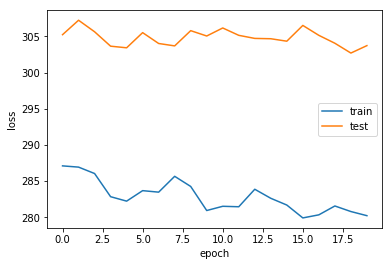

In [36]:
train(40, '1204_1', send=True)
lr = 1e-5
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
train(20, '1204_1', send=True, init_epoch=40)

# Convert to ONNX

In [5]:
model = SketchResModel()
model.load_state_dict(torch.load('models/1204_1/epoch_48.pth'))

In [6]:
import onnx

In [7]:
dummy_input = torch.FloatTensor(1, 1, 225, 225)

In [8]:
torch.onnx.export(model, dummy_input, 'SketchResModel.proto', verbose=True)

graph(%0 : Float(1, 1, 225, 225)
      %1 : Float(64, 1, 15, 15)
      %2 : Float(64)
      %3 : Float(64)
      %4 : Float(64)
      %5 : Float(64)
      %6 : Float(64)
      %7 : Long()
      %8 : Float(128, 64, 3, 3)
      %9 : Float(128)
      %10 : Float(128)
      %11 : Float(128)
      %12 : Float(128)
      %13 : Float(128)
      %14 : Long()
      %15 : Float(256, 128, 3, 3)
      %16 : Float(256)
      %17 : Float(256)
      %18 : Float(256)
      %19 : Float(256)
      %20 : Float(256)
      %21 : Long()
      %22 : Float(256, 256, 3, 3)
      %23 : Float(256)
      %24 : Float(256)
      %25 : Float(256)
      %26 : Float(256)
      %27 : Float(256)
      %28 : Long()
      %29 : Float(256, 256, 3, 3)
      %30 : Float(256)
      %31 : Float(256)
      %32 : Float(256)
      %33 : Float(256)
      %34 : Float(256)
      %35 : Long()
      %36 : Float(512, 256, 7, 7)
      %37 : Float(512)
      %38 : Float(512)
      %39 : Float(512)
      %40 : Float(512)
      %41 : Float

In [9]:
model = onnx.load('SketchResModel.proto')

In [10]:
from onnx_coreml import convert

In [11]:
coreml_model = convert(
    model,
    'classifier',
    image_input_names=['input'],
    image_output_names=['output'],
    class_labels=[i for i in range(10)],
)
coreml_model.save('SketchResModel.mlmodel')

1/33: Converting Node Type Conv
2/33: Converting Node Type BatchNormalization
3/33: Converting Node Type LeakyRelu
4/33: Converting Node Type MaxPool
5/33: Converting Node Type Conv
6/33: Converting Node Type BatchNormalization
7/33: Converting Node Type LeakyRelu
8/33: Converting Node Type MaxPool
9/33: Converting Node Type Conv
10/33: Converting Node Type BatchNormalization
11/33: Converting Node Type Conv
12/33: Converting Node Type BatchNormalization
13/33: Converting Node Type LeakyRelu
14/33: Converting Node Type Conv
15/33: Converting Node Type BatchNormalization
16/33: Converting Node Type LeakyRelu
17/33: Converting Node Type Conv
18/33: Converting Node Type BatchNormalization
19/33: Converting Node Type Add
20/33: Converting Node Type LeakyRelu
21/33: Converting Node Type MaxPool
22/33: Converting Node Type Conv
23/33: Converting Node Type BatchNormalization
24/33: Converting Node Type LeakyRelu
25/33: Converting Node Type Conv
26/33: Converting Node Type BatchNormalization
2